In [1]:
import os
import sys
import os
import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision.models as models
from torchvision.models import VGG16_Weights

import torchvision.transforms.functional as F

from torchvision.transforms.functional import to_tensor, resize, center_crop, rotate, adjust_brightness

## Constants

In [2]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

plt.style.use("dark_background")

IMG_SIZE = 512
MASK_SIZE = 128

EPOCHS = 150
PATIENCE = 5
BATCH_SIZE = 8

labels = ['Positive', 'Negative']
colors = ['olive' , 'lightblue']

## Utility Functions

In [3]:
def read_data_pathes(path):
    data_map = []
    for sub_dir_path in glob.glob(path+"*"):
        if not os.path.isdir(sub_dir_path):
            continue
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
        
    df = pd.DataFrame({'dirname' : data_map[::2], 'path' : data_map[1::2]})
    return df

def separate_and_sort_paths(df, base_len=89, end_img_len=4, end_mask_len=9):
    df_imgs = df[~df['path'].str.contains("mask")]
    df_masks = df[df['path'].str.contains("mask")]

    imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[base_len:-end_img_len]))
    masks = sorted(df_masks["path"].values, key=lambda x: int(x[base_len:-end_mask_len]))

    df = pd.DataFrame({'patient': df_imgs.dirname.values, 'image_path': imgs, 'mask_path': masks})

    return imgs, masks, df

def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

def prepare_sample_images(df, sample_pos_df, sample_neg_df, row_count):
    sample_pos_df = sample_pos_df['image_path'].values
    sample_neg_df = sample_neg_df['image_path'].values

    sample_imgs = []
    for neg, pos in zip(sample_neg_df, sample_pos_df):
        neg_img = cv2.resize(cv2.imread(neg), (IMG_SIZE, IMG_SIZE))
        pos_img = cv2.resize(cv2.imread(pos), (IMG_SIZE, IMG_SIZE))
        sample_imgs.extend([pos_img, neg_img])

    sample_pos_arr = np.vstack(sample_imgs[::2])
    sample_neg_arr = np.vstack(sample_imgs[1::2])

    return sample_pos_arr, sample_neg_arr


def upsample_dataset(initial_df):
    pos_counts = initial_df['diagnosis'].value_counts() 
    max_count = pos_counts.max()

    dfs = []
    for label, count in pos_counts.items():
        subset_df = initial_df[initial_df['diagnosis'] == label]
        if count < max_count:
            repeat_count = max_count - count
            repeated_subset_df = subset_df.sample(repeat_count, replace=True)
            dfs.append(repeated_subset_df)
    
    initial_df = pd.concat([initial_df] + dfs, ignore_index=True).sample(frac=1).reset_index(drop=True)
    return initial_df

In [4]:
def get_sample_df(df, type, expected, count, column=None):
    sample_df = df[df[type] == expected].sample(count)
    if column: return sample_df[column]
    return sample_df

def get_df_sample(df, type, expected, count):
    return get_sample_df(df, type, expected, count).values

def get_img_sample(df, type, expected, count):
    return get_sample_df(df, type, expected, count, column='image_path').values
    
def resize(img, size):
    return cv2.resize(cv2.imread(img), size)

def split(df, test_size):
    df1, df2 = train_test_split(df, stratify=df.diagnosis, test_size=test_size)
    return df1.reset_index(drop=True), df2.reset_index(drop=True) # Is this nessesary or we can del it, for cheating

def print_data_shapes(train_df, val_df, test_df):
    print(f"{'Dataset':<10} {'Shape':<15}")
    print(f"{'-'*25}")
    print(f"{'Train':<10} {train_df.shape}")
    print(f"{'Validation':<10} {val_df.shape}")
    print(f"{'Test':<10} {test_df.shape}")


## Plot Functions

In [5]:
from skimage.transform import resize

class PlotUtils:
    @staticmethod
    def _add_annotations(ax, values, offset=12, fontsize=15, fontweight='bold'):
        for i, value in enumerate(values):
            ax.annotate(
                int(value),
                xy=(i, value - offset),
                rotation=0,
                color='white',
                ha='center',
                verticalalignment='bottom',
                fontsize=fontsize,
                fontweight=fontweight,
            )
    
    @staticmethod
    def plot_histogram(df, ylabel='Image Count', title='Dataset Histogram'):
        ax = df.diagnosis.value_counts().plot(
            kind='bar', stacked=True, figsize=(10, 6), color=colors
        )
        PlotUtils._add_annotations(ax, df.diagnosis.value_counts().values)
        bounding_box = dict(boxstyle='round', fc='lightblue', ec='black')
        ax.text(
            1.2,
            2550,
            f"Total {len(df)} images",
            size=15,
            color='black',
            ha='center',
            va='center',
            bbox=bounding_box,
        )
        ax.set_xticklabels(labels, rotation=45, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=18, y=1.05)
    
    @staticmethod
    def plot_distribution(df, ylabel='Total Images', title='Dataset Distribution'):
        patients_by_diagnosis = (
            df.groupby(['patient', 'diagnosis'])['diagnosis']
            .size()
            .unstack()
            .fillna(0)
        )
        patients_by_diagnosis.columns = ["Positive", "Negative"]
        ax = patients_by_diagnosis.plot(
            kind='bar', stacked=True, figsize=(18, 10), color=colors, alpha=0.9
        )
        ax.legend(fontsize=20)
        ax.set_xlabel('Patients', fontsize=20)
        ax.set_ylabel(ylabel, fontsize=20)
        ax.set_title(title, fontsize=25, y=1.005)
        ax.set_xticklabels([])

    @staticmethod
    def general_plot(image_set, titles, cmaps, nrows, ncols, y=0, hstack=False, fontsize=15):
        fig = plt.figure(figsize=(10, 10))
        grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.1)

        for i, (data, title) in enumerate(zip(image_set, titles)):
            data = np.hstack(data) if hstack else data
            grid[i].imshow(data, cmap=cmaps[i])
            grid[i].set_title(title, fontsize=fontsize, y=y)
            grid[i].axis('off')
        
        plt.show()
            
    # // you may can combine this with the last plot method
    @staticmethod
    def plot_augmented_images(data, mask=False):
        ncols = len(data)
        plt.figure(figsize=(ncols * (IMG_SIZE / 100), IMG_SIZE / 100))
        plt.subplots_adjust(wspace=0, hspace=0)
        
        for idx, img in enumerate(data):
            if mask: img = img.numpy().astype(np.float32)[0, :, :]
            else:    img = img.numpy().transpose(1, 2, 0)
            plt.subplot(1, ncols, idx + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

    @staticmethod
    def plot_samples(samples, num_samples=5):
        num_samples = min(num_samples, len(samples))
        for i in range(num_samples):
            images, masks, outputs = samples[i]
            PlotUtils._plot_sample(images[0], masks[0], outputs[0])

    @staticmethod            
    def _plot_sample(image, mask, output, title_fontsize=14):
        image = image.numpy().transpose(1, 2, 0)
        mask = mask.numpy().squeeze()
        pred_mask = (output.numpy().squeeze() >= 0.3).astype(np.uint8) # It could be 0.5

        fig, axes = plt.subplots(1, 4, figsize=(18, 6))
        
        titles = ['Input Image', 'Ground Truth Mask', 'Predicted Mask', 'Detection Heatmap']
        cmaps = ['gray', 'Blues', 'Reds']
        images = [image, mask, pred_mask]
        for i, (img, title) in enumerate(zip(images, titles)):
            cmap = cmaps[i] if cmaps else None
            axes[i].imshow(img, cmap=cmap)
            axes[i].set_title(title, fontsize=title_fontsize)
            axes[i].axis('off')
        
        axes[3].imshow(mask, cmap=cmaps[1], alpha=0.5)
        axes[3].imshow(pred_mask, cmap=cmaps[2], alpha=0.5)
        axes[3].set_title(titles[3], fontsize=title_fontsize)
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'r', label='Train Loss')
        plt.plot(epochs, val_losses, 'b', label='Val Loss')
        plt.title('Loss', fontsize=14)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_dice_scores, 'r', label='Train Dice')
        plt.plot(epochs, val_dice_scores, 'b', label='Val Dice')
        plt.title('Dice Coefficient', fontsize=14)
        plt.legend()

        plt.show()


## Metric Functions

In [6]:
def dice_coefficient(output, target, smooth=1e-6):
    # Binarize output
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    return (2.0 * intersection + smooth) / (output.sum() + target.sum() + smooth)

def iou_score(output, target, smooth=1e-6):
    # Binarize output
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(output, target, smooth=1e-6):
    return 1 - dice_coefficient(output, target)

## Implementation

In [7]:
df = read_data_pathes(DATA_PATH)
# df.head(5)

In [8]:
imgs, masks, df = separate_and_sort_paths(df)

df['diagnosis'] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
# df.head()

In [9]:
sample_pos_df = get_sample_df(df, 'diagnosis', expected=1, count=3)
sample_neg_df = get_sample_df(df, 'diagnosis', expected=0, count=3)

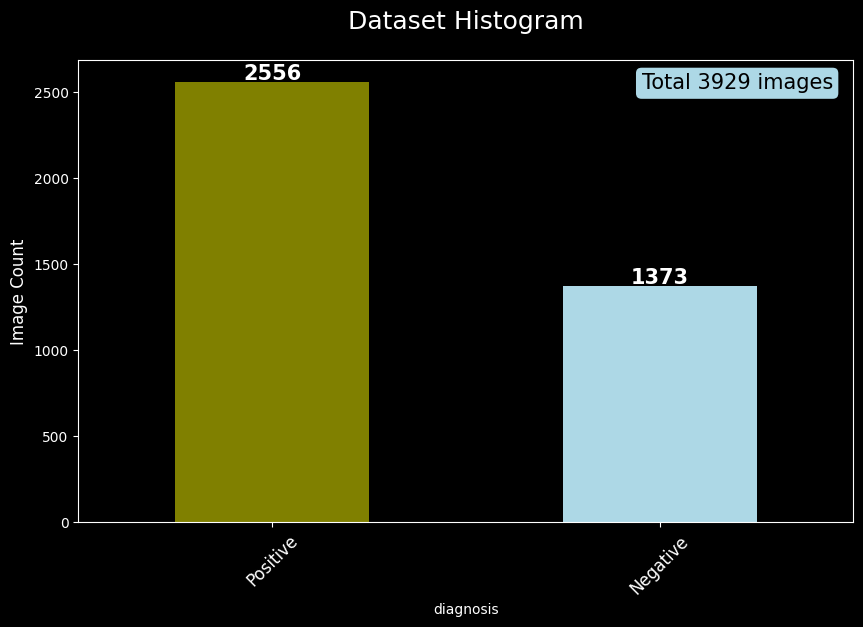

In [10]:
PlotUtils.plot_histogram(df)

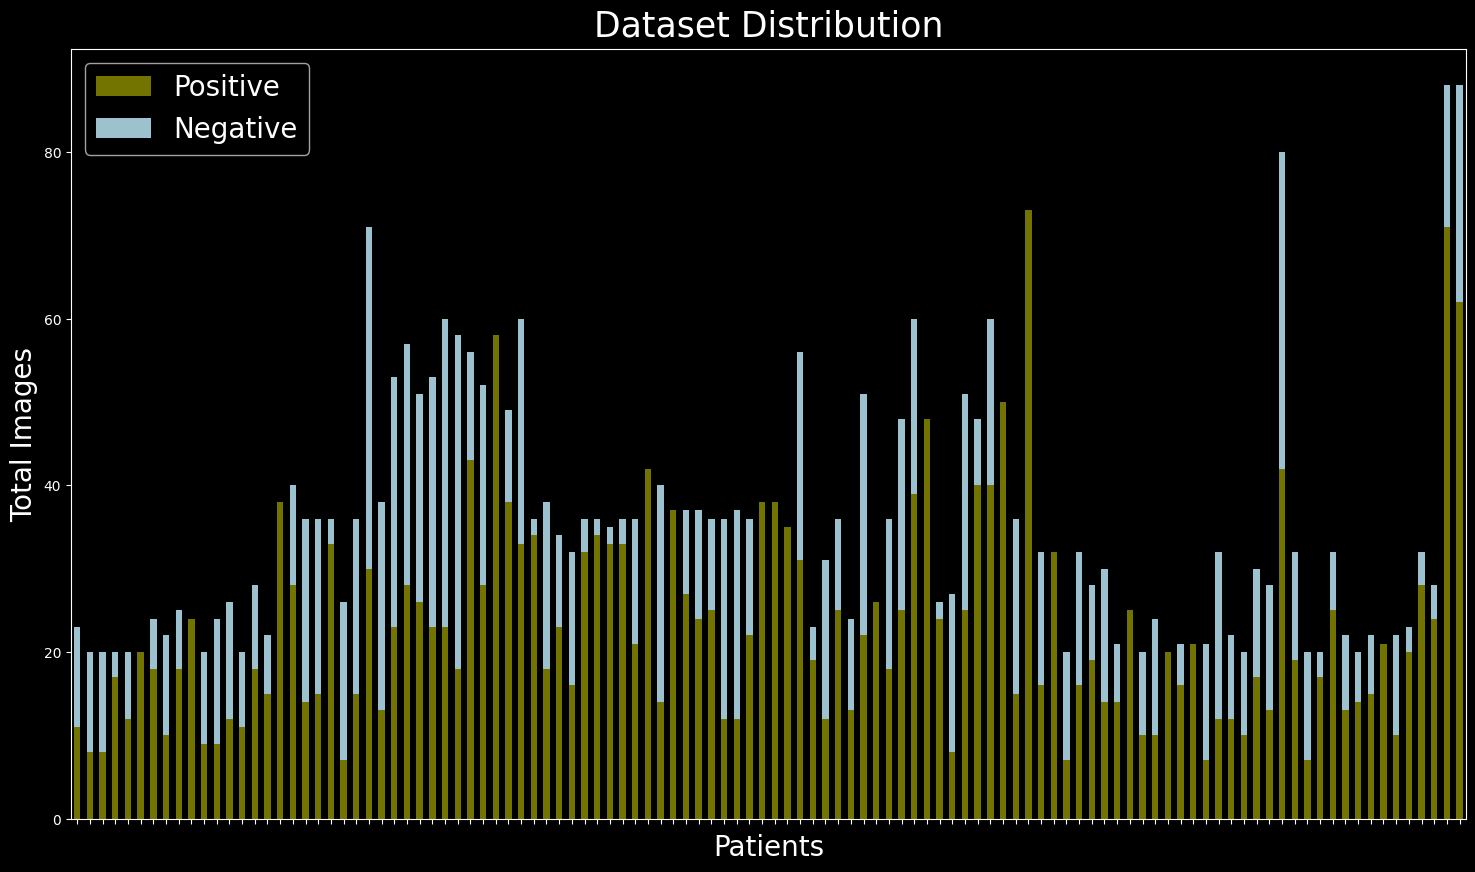

In [11]:
PlotUtils.plot_distribution(df)

In [12]:
sample_df = sample_pos_df.values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

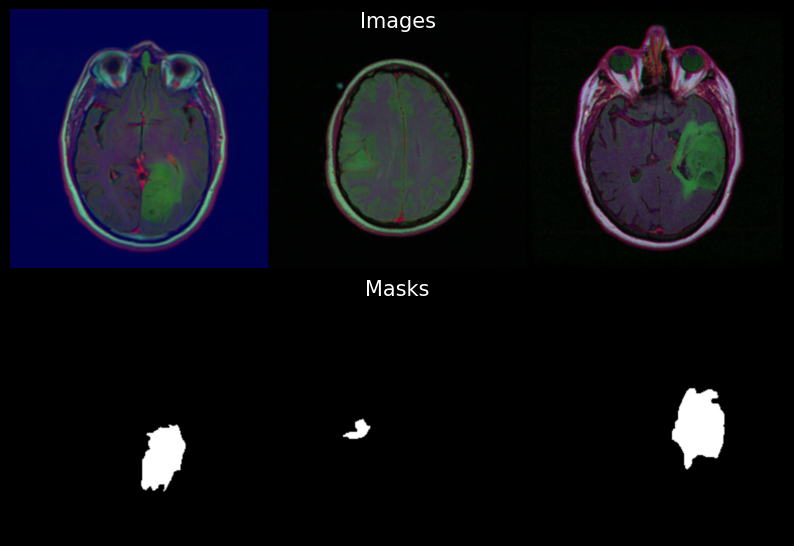

In [13]:
PlotUtils.general_plot(
    image_set=[np.array(sample_imgs[::2]), np.array(sample_imgs[1::2])], 
    titles=['Images', 'Masks'],
    cmaps = [None, None],
    nrows=2, ncols=1, y=0.9, hstack=True
)

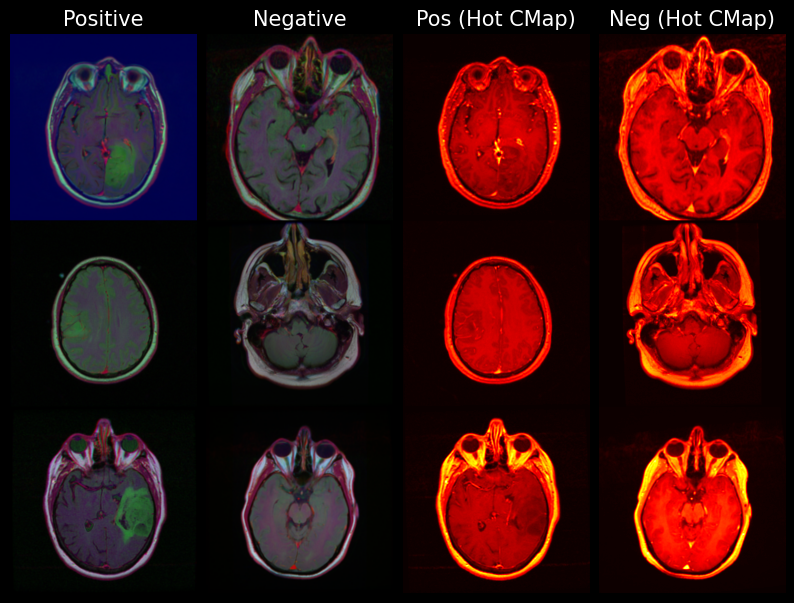

In [14]:
positive, negative = prepare_sample_images(df, sample_pos_df, sample_neg_df, row_count=3)
PlotUtils.general_plot(
    image_set=[positive, negative, positive[:, :, 0], negative[:, :, 0]],
    titles=['Positive', 'Negative', 'Pos (Hot CMap)', 'Neg (Hot CMap)'],
    cmaps=[None, None, 'hot', 'hot'],
    nrows=1, ncols=4, y=1
)

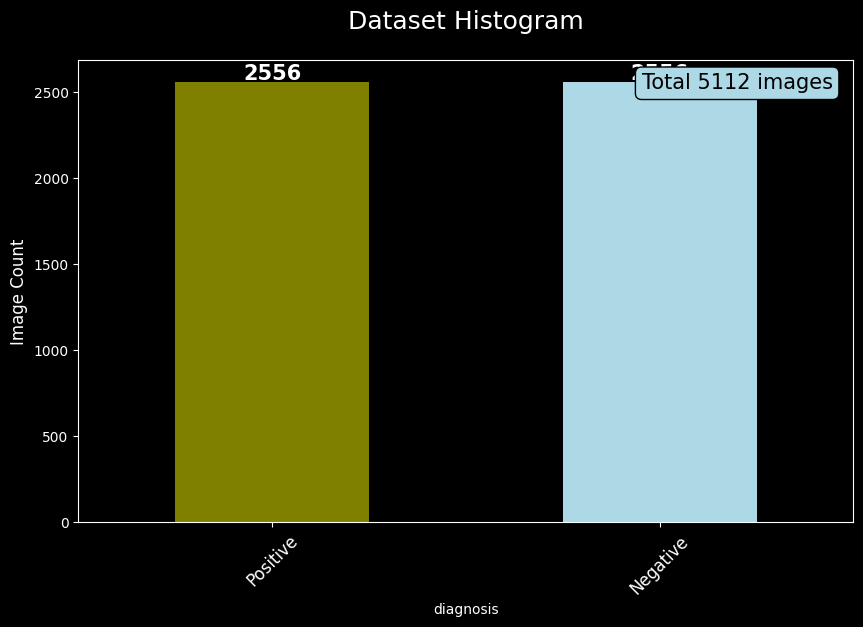

In [16]:
df = upsample_dataset(df)
PlotUtils.plot_histogram(df)

In [17]:
train_df, temp_df = split(df, test_size=0.2)
test_df, val_df = split(temp_df, test_size=0.5)

print_data_shapes(train_df, val_df, test_df)

Dataset    Shape          
-------------------------
Train      (4089, 4)
Validation (512, 4)
Test       (511, 4)


In [18]:
from torchvision.transforms.functional import resize
class AugmentPair:
    def __init__(self, rotation_range=15, scale_range=0.2, brightness_range=(0.9, 1.1)):
        self.rotation_range = rotation_range
        self.scale_range = scale_range
        self.brightness_range = brightness_range

    def rotate(self, input, angle):
        return rotate(input, angle)

    def scale(self, data, factor):
        width, height = data.size
        data = resize(data, (int(height * factor), int(width * factor)))
        return center_crop(data, (height, width))
    
    def adjust_brightness(self, input, factor):
        return adjust_brightness(input, factor)        
        
    def __call__(self, pair):
        image, mask = pair

        angle = np.random.uniform(-self.rotation_range, self.rotation_range)
        image = self.rotate(image, angle)
        mask = self.rotate(mask, angle)

        factor = np.random.uniform(1 - self.scale_range, 1 + self.scale_range)
        image = self.scale(image, factor)
        mask = self.scale(mask, factor)

        image = self.adjust_brightness(image, factor=np.random.uniform(*self.brightness_range))

        return image, mask

class MRIDataset(Dataset):
    def __init__(self, df, transformer=None):
        self.df = df
        self.transformer = transformer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image and mask with OpenCV
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)  # 0 for grayscale

        # Convert to PIL Image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mask = Image.fromarray(mask)

        if self.transformer:
            image, mask = self.transformer((image, mask))

        # Convert to tensors
        image = to_tensor(image)
        mask = torch.tensor(np.array(mask) / 255.0, dtype=torch.float32).unsqueeze(0)

        return image, resize(mask, MASK_SIZE)


train_dataset = MRIDataset(train_df, transformer=AugmentPair())
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

val_dataset = MRIDataset(val_df, transformer=None)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

test_dataset = MRIDataset(test_df, transformer=None)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 128, 128])


In [19]:
combined_df = pd.concat([sample_pos_df, sample_neg_df], ignore_index=True)
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
dataloader_ = DataLoader(MRIDataset(shuffled_df, transformer=AugmentPair()), 
                         batch_size=32, num_workers=4, shuffle=True)

images_, masks_ = next(iter(dataloader_))

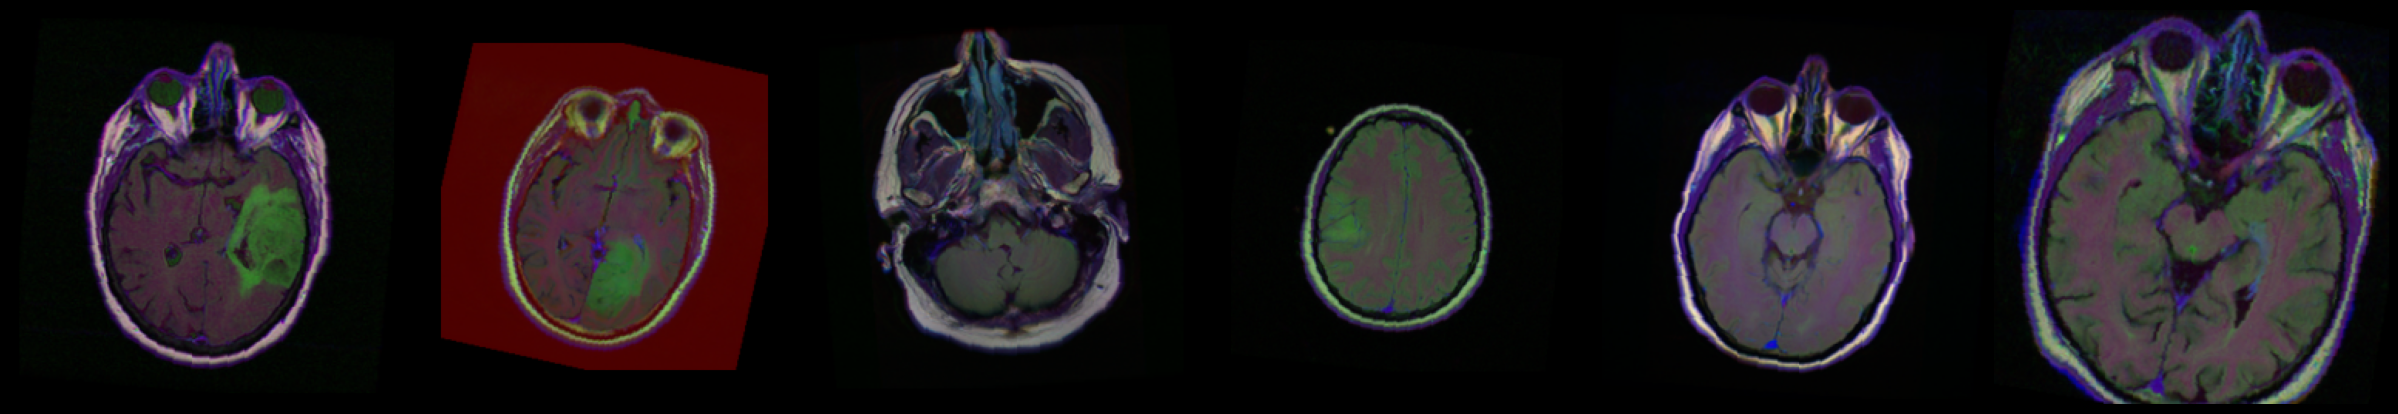

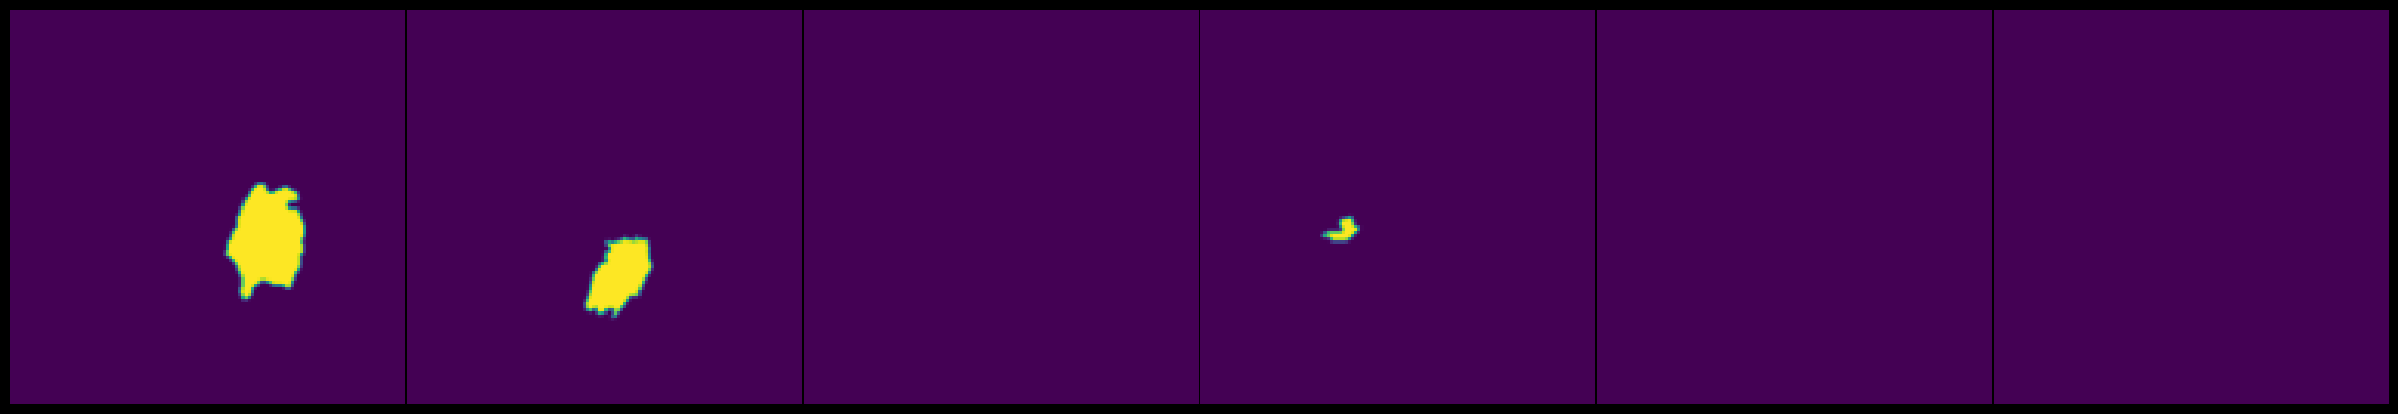

In [20]:
PlotUtils.plot_augmented_images(images_, mask=False)
PlotUtils.plot_augmented_images(masks_, mask=True)

In [21]:
class VGGEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(VGGEncoder, self).__init__()
        
        weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        vgg = models.vgg16(weights=weights)
        features = list(vgg.features.children())

        self.block1 = nn.Sequential(*features[:5])
        self.block2 = nn.Sequential(*features[5:10]) 
        self.block3 = nn.Sequential(*features[10:17])
        self.block4 = nn.Sequential(*features[17:24])
        self.block5 = nn.Sequential(*features[24:31])

    def forward(self, x):
        skip_connections = []
        
        x = self.block1(x)
        skip_connections.append(x)
        
        x = self.block2(x)
        skip_connections.append(x)
        
        x = self.block3(x)
        skip_connections.append(x)
        
        x = self.block4(x)
        skip_connections.append(x)
        
        x = self.block5(x)

        return x, skip_connections[::-1]  # Reverse for decoding
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upsample(x) 
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x)) 
        x = self.relu(self.conv2(x))
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_classes=1):
        super(UNetDecoder, self).__init__()
        self.decoder4 = DecoderBlock(512, 512, 256)  # Block 5 to Block 4
        self.decoder3 = DecoderBlock(256, 256, 128)  # Block 4 to Block 3
        self.decoder2 = DecoderBlock(128, 128, 64)   # Block 3 to Block 2
        self.decoder1 = DecoderBlock(64, 64, 32)     # Block 2 to Block 1

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x, skips):
        x = self.decoder4(x, skips[0])  # Skip from Block 4
        x = self.decoder3(x, skips[1])  # Skip from Block 3
        x = self.decoder2(x, skips[2])  # Skip from Block 2
        x = self.decoder1(x, skips[3])  # Skip from Block 1
        x = self.final_conv(x)          # Output layer
        return x

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.encoder = VGGEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        # Encoder forward pass
        x, skips = self.encoder(x)  
        # Decoder forward pass
        x = self.decoder(x, skips)  
        return x

In [22]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    for images, masks in tqdm(dataloader, desc="Training", leave=False):    
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks) + criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks).item()
        total_iou += iou_score(outputs, masks).item()

    return (total_loss / len(dataloader)), (total_dice / len(dataloader)), (total_iou / len(dataloader))

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = dice_loss(outputs, masks) + criterion(outputs, masks)
            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)


In [23]:
def test_model(model, dataloader, device):
    model.eval()
    total_dice, total_iou = 0, 0
    samples = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

            # Store sample predictions for visualization
            samples.append((images.cpu(), masks.cpu(), outputs.cpu()))

    avg_dice = total_dice / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_dice, avg_iou, samples

In [23]:
model = UNet()
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=3e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]  


UNet(
  (encoder): VGGEncoder(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [24]:
best_val_loss = np.inf  
early_stop_counter = 0

train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []

for epoch in range(EPOCHS):
    train_loss, train_dice, train_iou = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_dice, val_iou = validate_one_epoch(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete.")

Epoch 1/10
Train Loss: 1.0880, Train Dice: 0.0000, Train IoU: 0.0000
Val Loss: 1.0338, Val Dice: 0.0051, Val IoU: 0.0026


Epoch 2/10
Train Loss: 0.4935, Train Dice: 0.5350, Train IoU: 0.3869
Val Loss: 0.4230, Val Dice: 0.6045, Val IoU: 0.4386


Epoch 3/10
Train Loss: 0.3190, Train Dice: 0.7010, Train IoU: 0.5469
Val Loss: 0.2773, Val Dice: 0.7418, Val IoU: 0.5950


Epoch 4/10
Train Loss: 0.2596, Train Dice: 0.7557, Train IoU: 0.6136
Val Loss: 0.2353, Val Dice: 0.7798, Val IoU: 0.6417


Epoch 5/10
Train Loss: 0.1939, Train Dice: 0.8178, Train IoU: 0.6947
Val Loss: 0.1481, Val Dice: 0.8621, Val IoU: 0.7582


Epoch 6/10
Train Loss: 0.1685, Train Dice: 0.8416, Train IoU: 0.7286
Val Loss: 0.1841, Val Dice: 0.8278, Val IoU: 0.7078


Epoch 7/10
Train Loss: 0.1724, Train Dice: 0.8382, Train IoU: 0.7253
Val Loss: 0.1607, Val Dice: 0.8488, Val IoU: 0.7387


Epoch 8/10
Train Loss: 0.1476, Train Dice: 0.8612, Train IoU: 0.7579
Val Loss: 0.1337, Val Dice: 0.8754, Val IoU: 0.7795


Epoch 9/10
Train Loss: 0.1366, Train Dice: 0.8717, Train IoU: 0.7736
Val Loss: 0.1088, Val Dice: 0.8994, Val IoU: 0.8179


Epoch 10/10
Train Loss: 0.1210, Train Dice: 0.8863, Train IoU: 0.7965
Val Loss: 0.1070, Val Dice: 0.9002, Val IoU: 0.8191
Training complete.


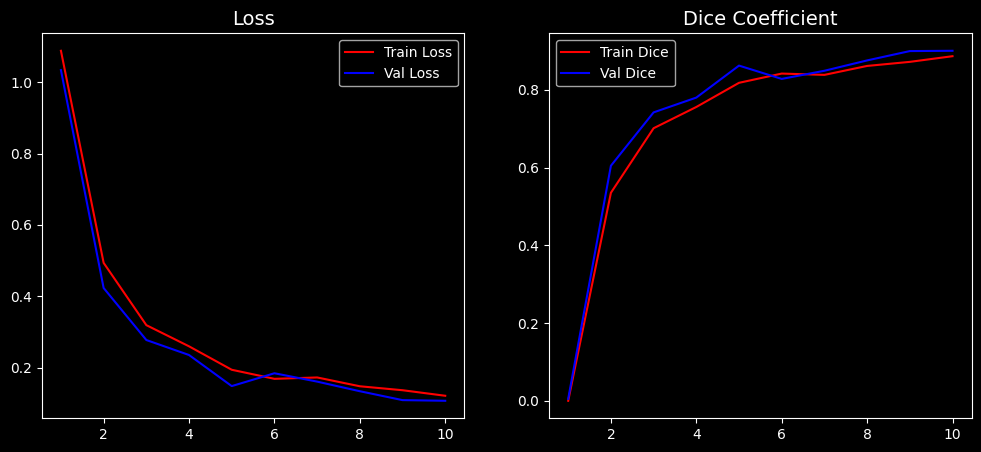

In [26]:
PlotUtils.plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores)

In [ ]:
# state_dict = torch.load("best_model.pth", map_location=device)
# model.load_state_dict(state_dict)
# model.to(device) 
# test_loss, test_dice, test_iou = validate_one_epoch(model, test_dataloader, criterion, device)
# print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")

/tmp/ipykernel_23/4013297025.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pth", map_location=device)
                             

Test Loss: 0.1137, Test Dice: 0.8941, Test IoU: 0.8090


In [28]:
avg_dice, avg_iou, samples = test_model(model, test_dataloader, device)
print(f"Test Avg Dice Score: {avg_dice:.4f}, Test Avg IoU Score: {avg_iou:.4f}")

Test Avg Dice Score: 0.8941, Test Avg IoU Score: 0.8090


In [ ]:
# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")


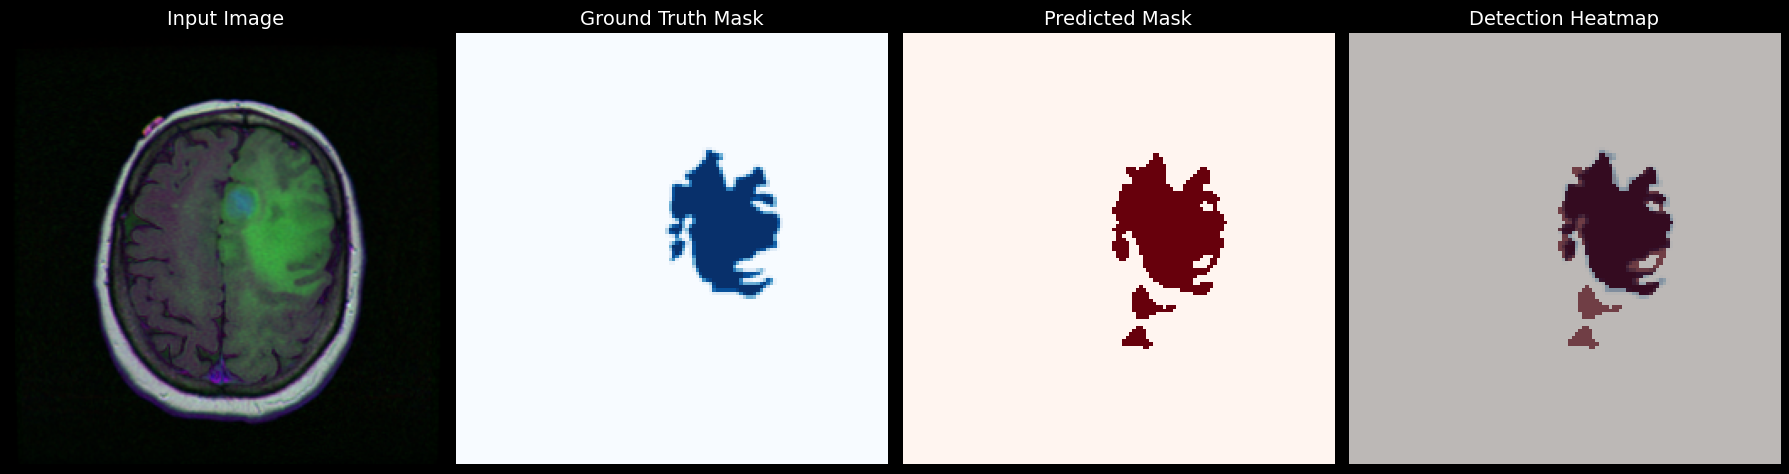

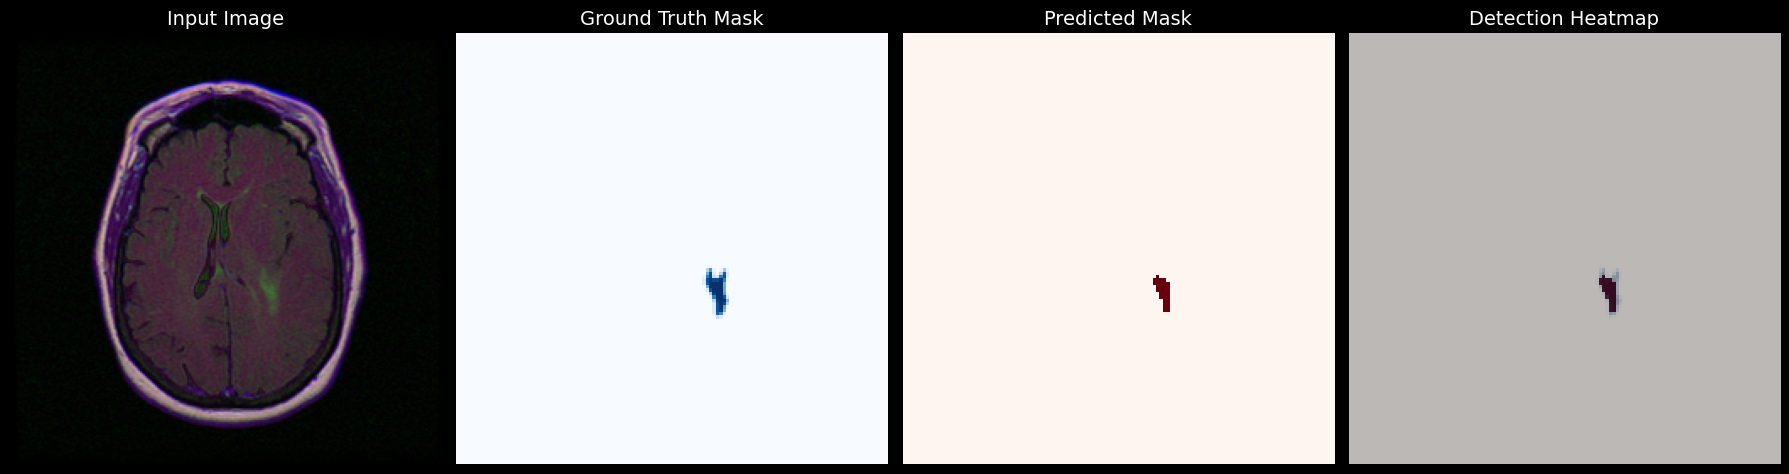

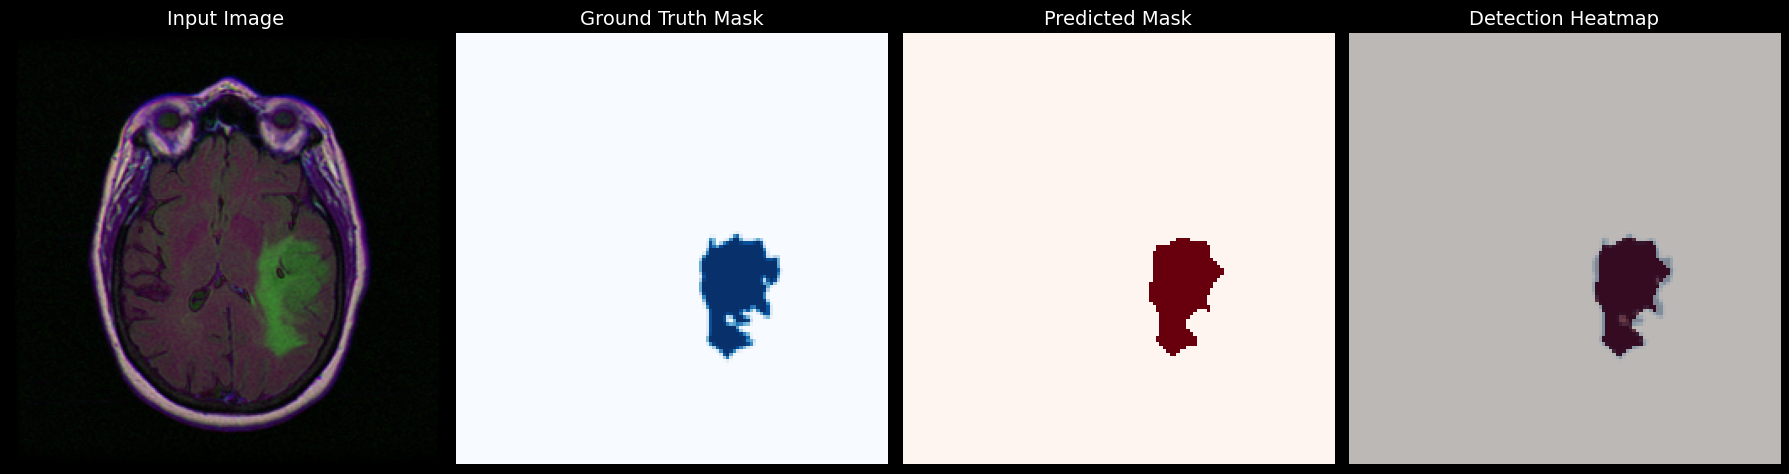

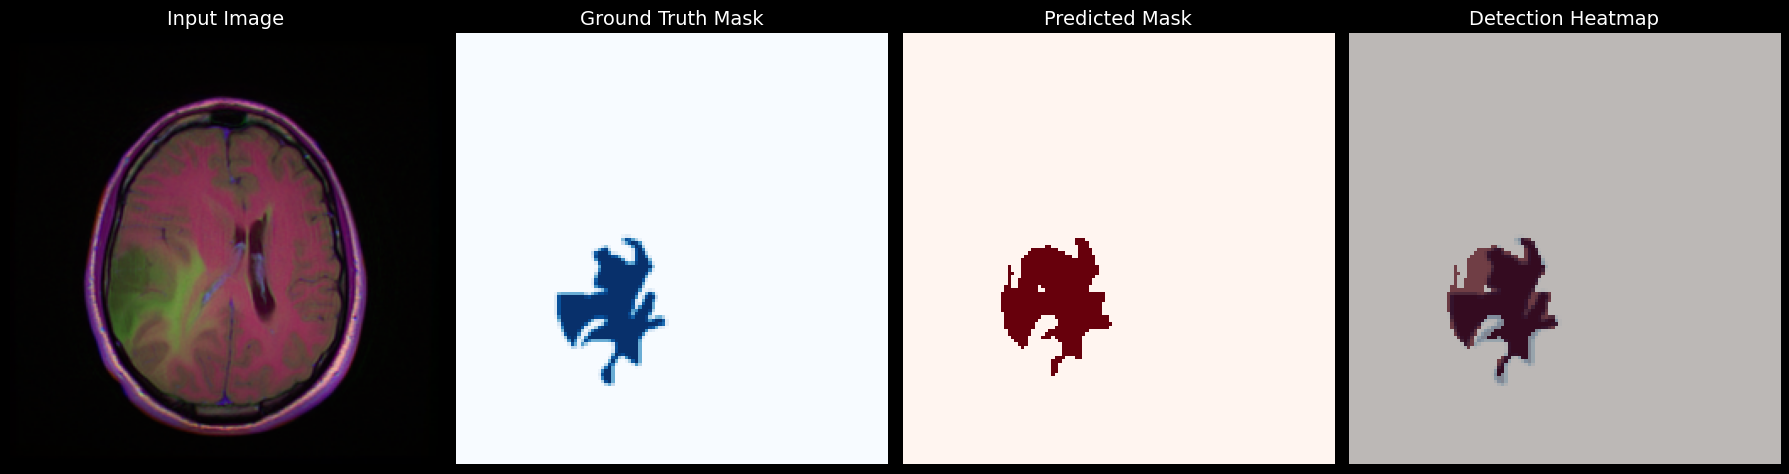

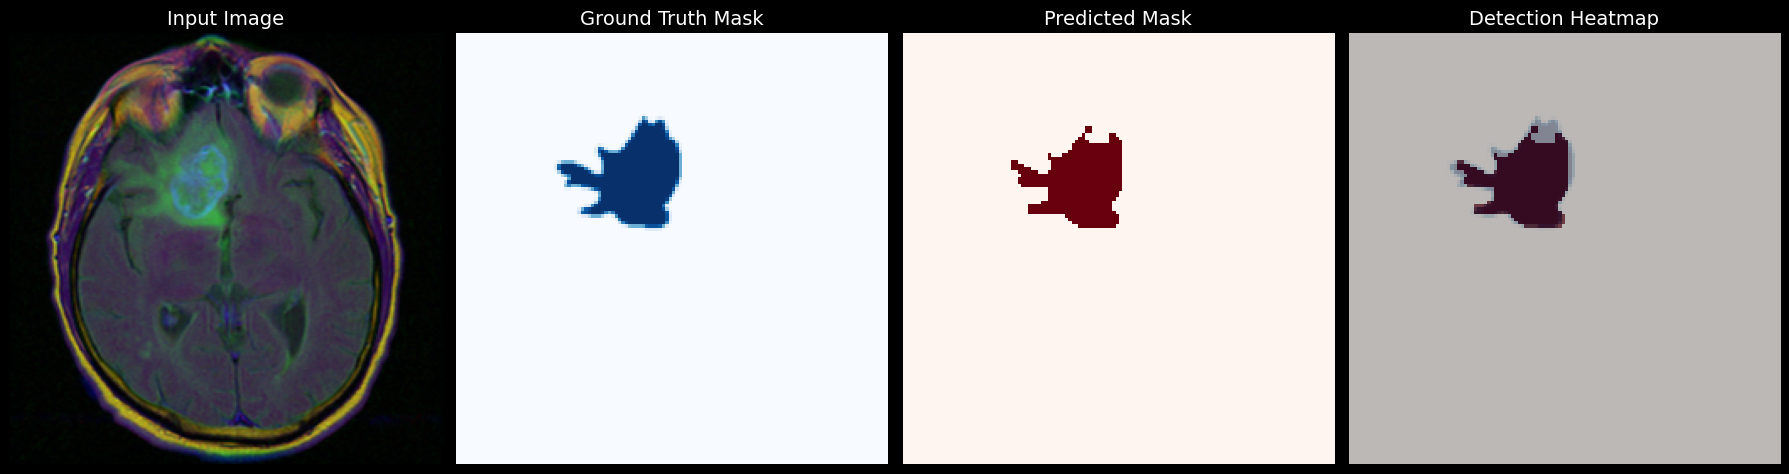

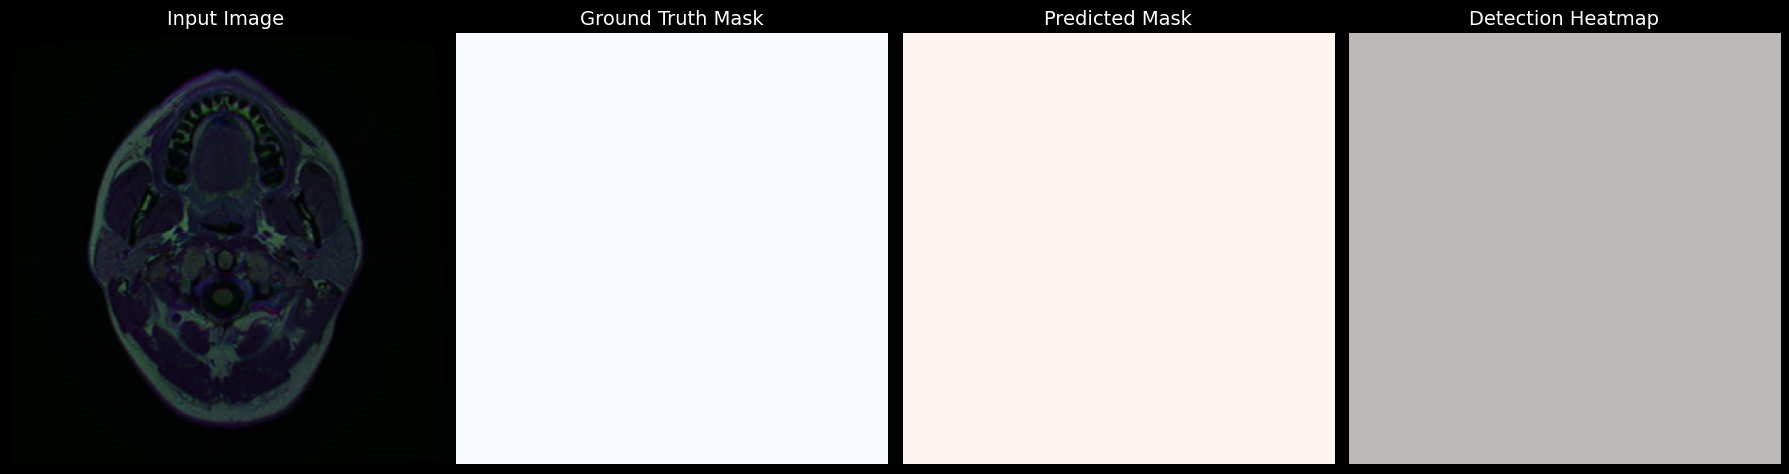

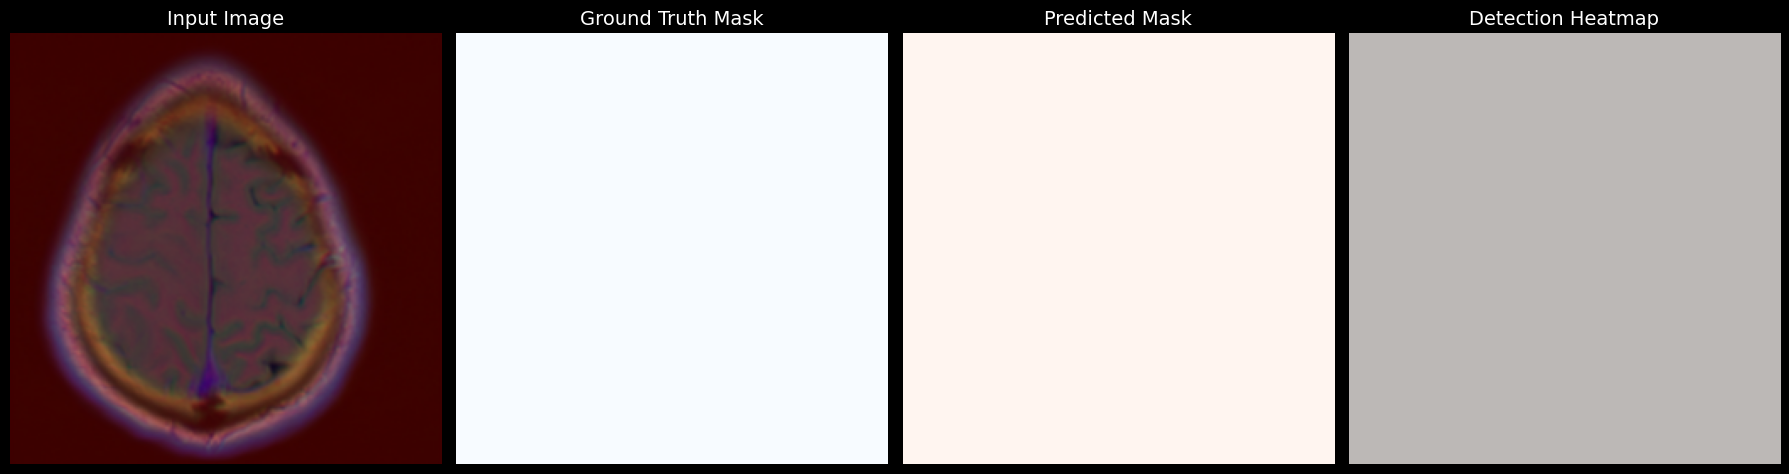

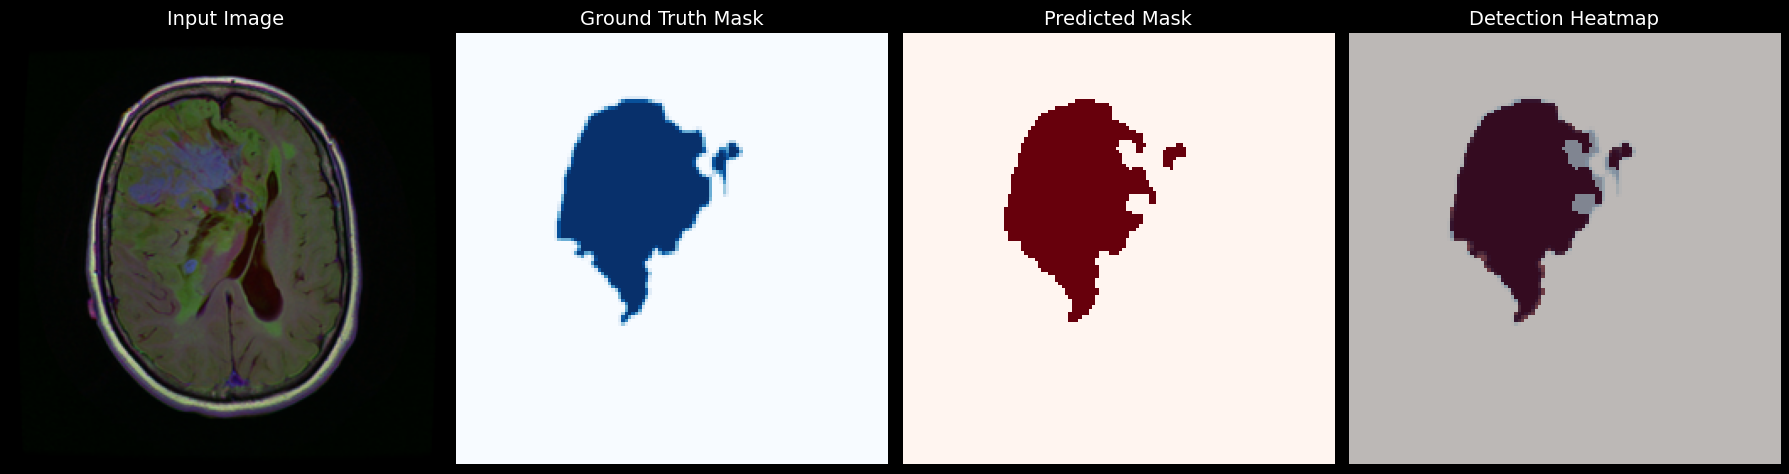

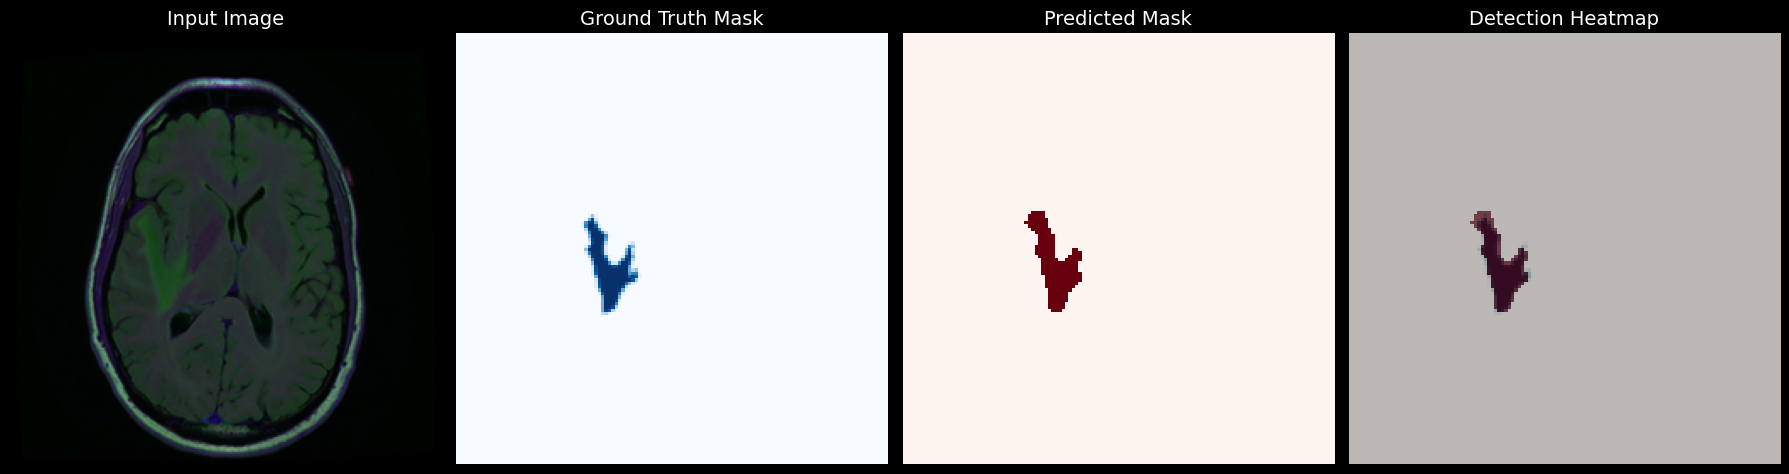

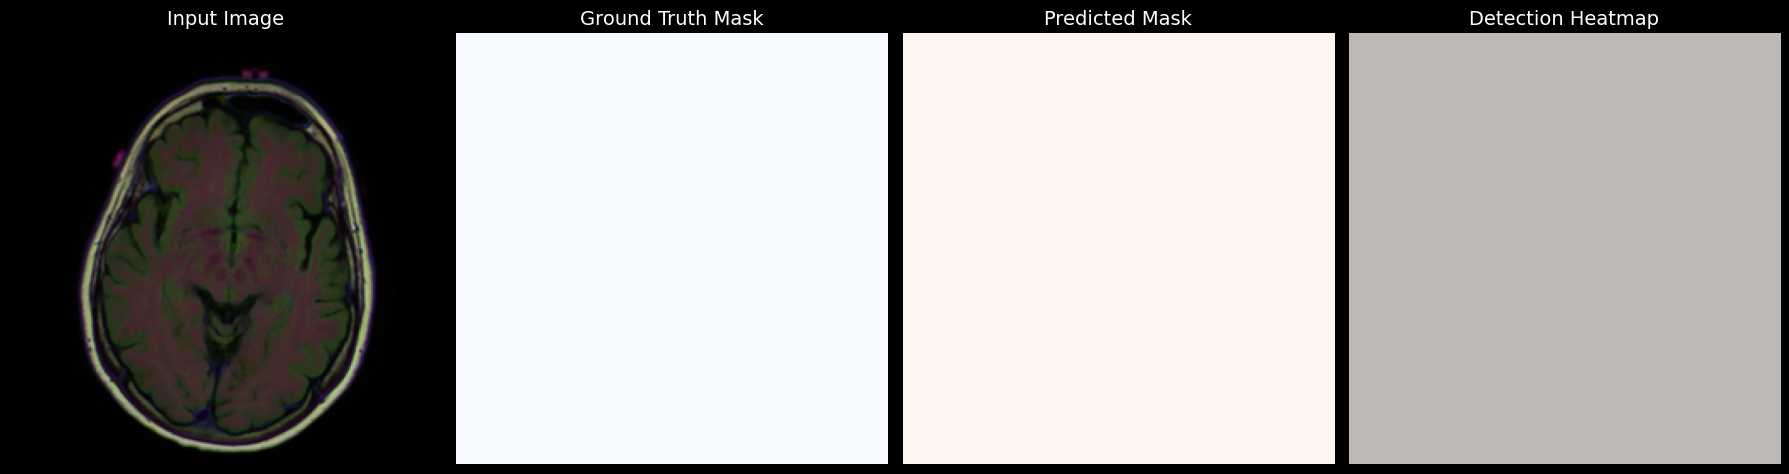

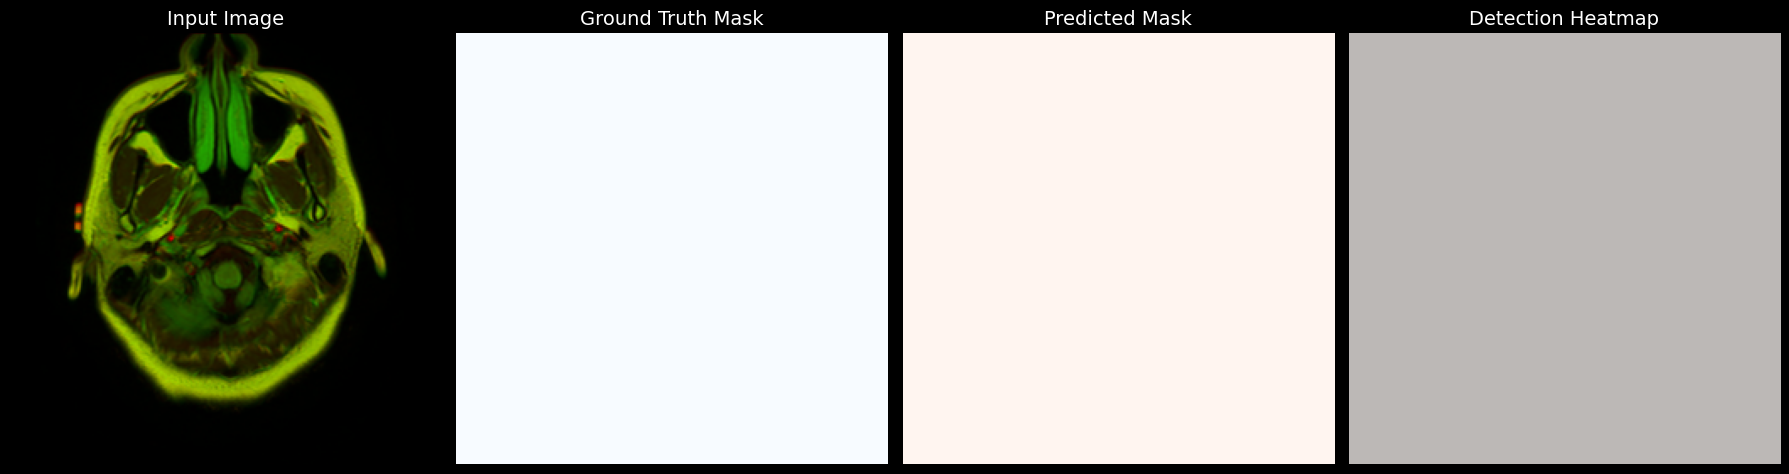

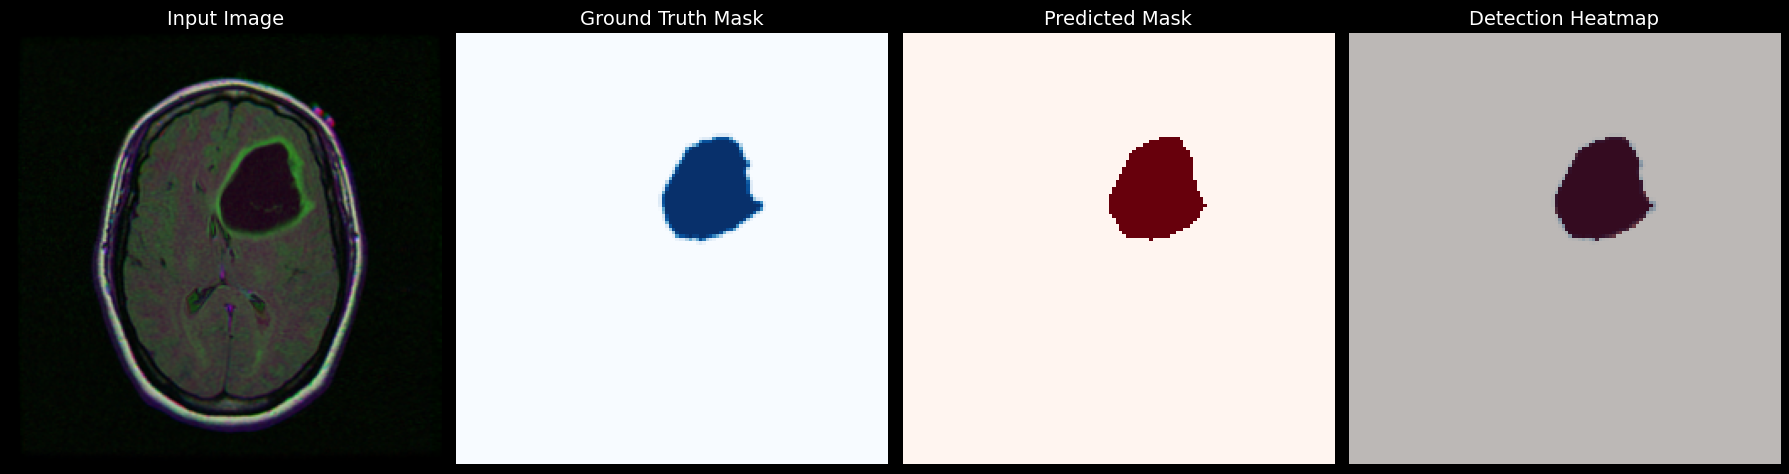

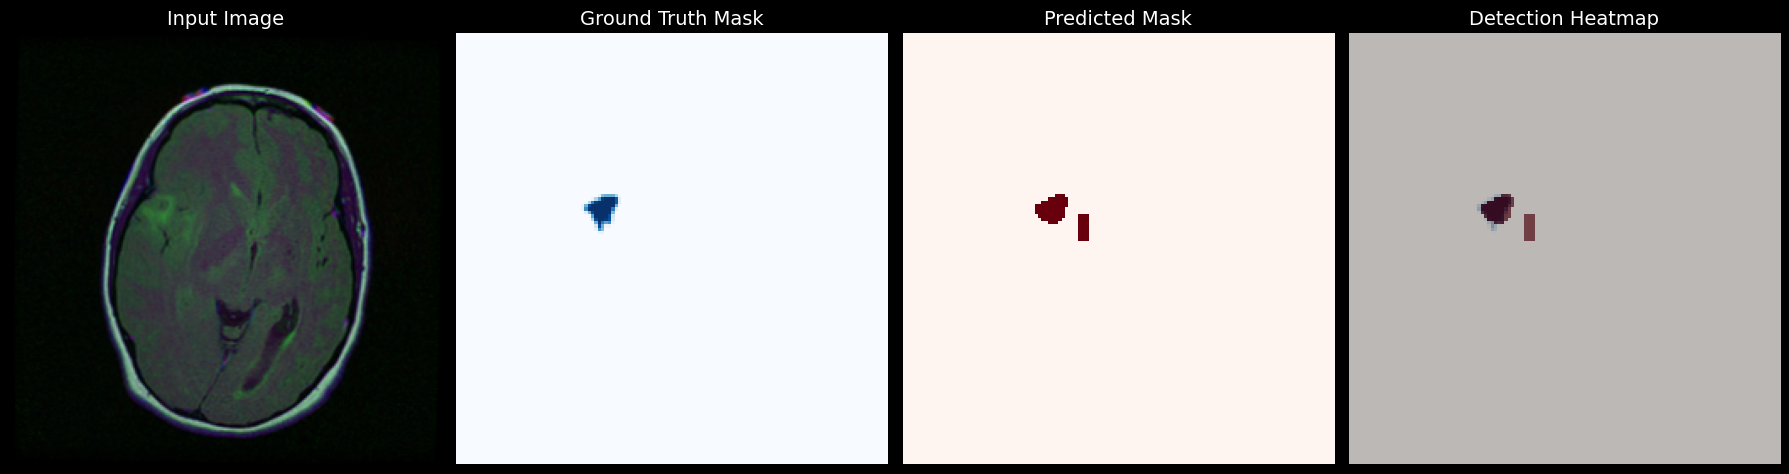

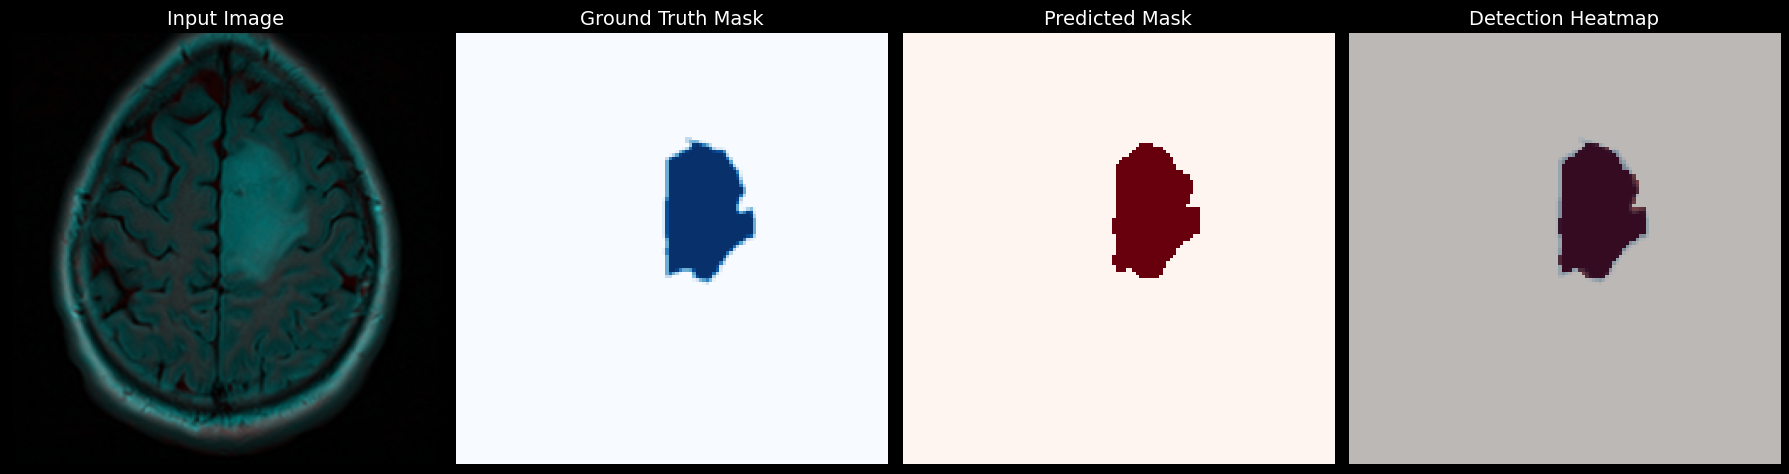

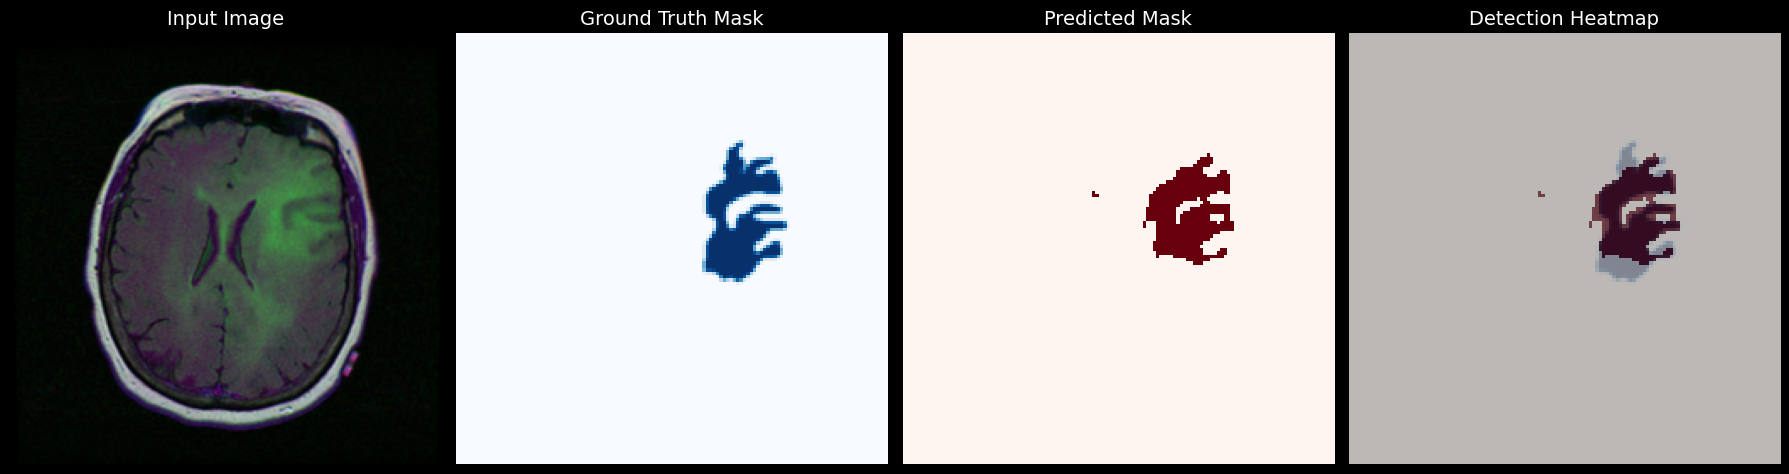

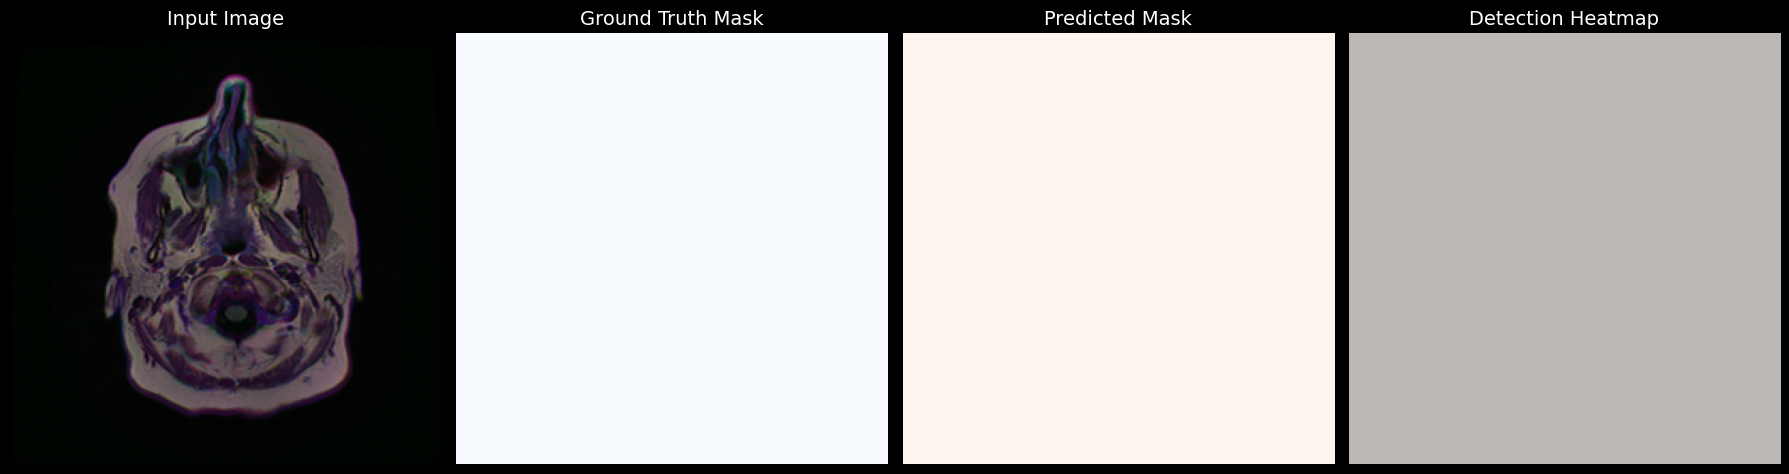

In [58]:
PlotUtils.plot_samples(samples, num_samples=25)